# Piano vs Orchestra Album Trends in the U.S. (1900–2020)

Research Question: By analyzing metadata from MusicBrainz, can we quantify whether piano-related recordings have grown or declined relative to orchestral recordings across the 20th century

this eda.ipynb is just visualizing some csv from the data folder.

## 0) Import & Setting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("../data")
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

def read_csv_safe(p):
    p = DATA / p
    df = pd.read_csv(p)
    print(f" Loaded {p.name}: {df.shape[0]:,} rows × {df.shape[1]} cols")
    return df

## 1) Load all datasets

In [3]:
raw = read_csv_safe("us_classical_raw.csv")
counts_simple = read_csv_safe("us_classical_counts_by_decade.csv")
refined = read_csv_safe("us_classical_refined_hybrid.csv")
counts_h = read_csv_safe("us_classical_counts_hybrid_by_decade.csv")


 Loaded us_classical_raw.csv: 163 rows × 10 cols
 Loaded us_classical_counts_by_decade.csv: 14 rows × 3 cols
 Loaded us_classical_refined_hybrid.csv: 141 rows × 12 cols
 Loaded us_classical_counts_hybrid_by_decade.csv: 27 rows × 3 cols


## 2) Quick schema & sanity checks

In [4]:
display(raw.head(3))
display(refined.head(3))
raw_cols = set(raw.columns)
ref_cols = set(refined.columns)
print("Common cols:", sorted(raw_cols & ref_cols))
print("Only in raw:", sorted(raw_cols - ref_cols))
print("Only in refined:", sorted(ref_cols - raw_cols))

assert raw["year"].between(1900, 2025, inclusive="left").fillna(True).all()
assert refined["year"].between(1900, 2025, inclusive="left").fillna(True).all()

dup = refined.duplicated(subset=[c for c in ["rg_id","release_title"] if c in refined.columns]).sum()
print("Possible duplicates in refined:", dup)


,rg_id,title,first_release_date,release_title,release_date,release_country,primary_type,genre_type,year,decade
0,e1e06c82-8228-361e-ac25-5a69c6a79028,Classical Music for People Who Hate Classical ...,2001,Classical Music for People Who Hate Classical ...,2001,US,Album,Piano,2001.0,2000.0
1,e55cdbb0-e04a-3c90-9bee-534d8255f75e,Piano Concerto No. 3 / Solo Piano Works,2000,Piano Concerto No. 3 / Solo Piano Works,2000,US,Album,Piano,2000.0,2000.0
2,0eaae045-96ce-4b97-966f-7a3849276f51,Classical Piano Collection,2005,Classical Piano Collection,2005,US,Album,Piano,2005.0,2000.0


,rg_id,title,first_release_date,release_title,release_date,release_country,primary_type,genre_type,year,decade,disambiguation,genre_refined
0,e1e06c82-8228-361e-ac25-5a69c6a79028,Classical Music for People Who Hate Classical ...,2001,Classical Music for People Who Hate Classical ...,2001,US,Album,Piano,2001.0,2000,NaN,Unknown
1,e55cdbb0-e04a-3c90-9bee-534d8255f75e,Piano Concerto No. 3 / Solo Piano Works,2000,Piano Concerto No. 3 / Solo Piano Works,2000,US,Album,Piano,2000.0,2000,NaN,Hybrid
2,0eaae045-96ce-4b97-966f-7a3849276f51,Classical Piano Collection,2005,Classical Piano Collection,2005,US,Album,Piano,2005.0,2000,NaN,PianoSolo


Common cols: ['decade', 'first_release_date', 'genre_type', 'primary_type', 'release_country', 'release_date', 'release_title', 'rg_id', 'title', 'year']
Only in raw: []
Only in refined: ['disambiguation', 'genre_refined']
Possible duplicates in refined: 0


## 3) Raw → Simple counts

In [6]:
cs = counts_simple.copy()
if "album_count" in cs.columns and "count" not in cs.columns:
    cs = cs.rename(columns={"album_count": "count"})
    if cs["decade"].dtype != int:
        cs["decade"] = cs["decade"].astype(int)

br = raw.dropna(subset=["year"]).assign(decade=lambda d: (d["year"]//10).astype(int)*10) \
        .groupby("decade").size().reset_index(name="count").sort_values("decade")

display(cs.sort_values("decade").head())
display(br.head())

merged_simple = cs.merge(br, on="decade", how="outer", suffixes=("_file","_recomp")).fillna(0)

for c in ["count_file", "count_recomp"]:
    if c not in merged_simple.columns:
        print("Columns now:", merged_simple.columns.tolist())
        raise KeyError(f"'{c}' column not found after merge.")
    merged_simple[c] = pd.to_numeric(merged_simple[c], errors="coerce").fillna(0).astype(int)

merged_simple["diff"] = merged_simple["count_file"] - merged_simple["count_recomp"]

display(merged_simple.sort_values("decade"))
print("Max abs diff:", merged_simple["diff"].abs().max())


,decade,genre_type,count
0,1940,Piano,1
1,1950,Orchestra,1
2,1950,Piano,2
3,1960,Piano,3
4,1970,Piano,8


,decade,count
0,1940,1
1,1950,3
2,1960,4
3,1970,8
4,1980,25


,decade,genre_type,count_file,count_recomp,diff
0,1940,Piano,1,1,0
1,1950,Orchestra,1,3,-2
2,1950,Piano,2,3,-1
3,1960,Piano,3,4,-1
4,1970,Piano,8,8,0
5,1980,Orchestra,2,25,-23
6,1980,Piano,23,25,-2
7,1990,Orchestra,8,52,-44
8,1990,Piano,43,52,-9
9,2000,Orchestra,3,42,-39


Max abs diff: 44


## 4) Refined(Hybrid)

In [ ]:
ref_dist = refined["genre_refined"].value_counts(dropna=False)
display(ref_dist.to_frame("n"))

pivot_h = counts_h.pivot(index="decade", columns="genre_refined", values="album_count").fillna(0)
pivot_h = pivot_h.reindex(sorted(pivot_h.index))
display(pivot_h.head())

,n
genre_refined,
PianoSolo,51
Hybrid,47
Unknown,27
Orchestra,16


genre_refined,Hybrid,Orchestra,PianoSolo,Unknown
decade,,,,
1940,1.0,0.0,0.0,0.0
1950,2.0,1.0,0.0,0.0
1960,2.0,0.0,0.0,2.0
1970,3.0,1.0,3.0,0.0
1980,13.0,3.0,5.0,3.0


## 5) Plots — Trend & Ratio

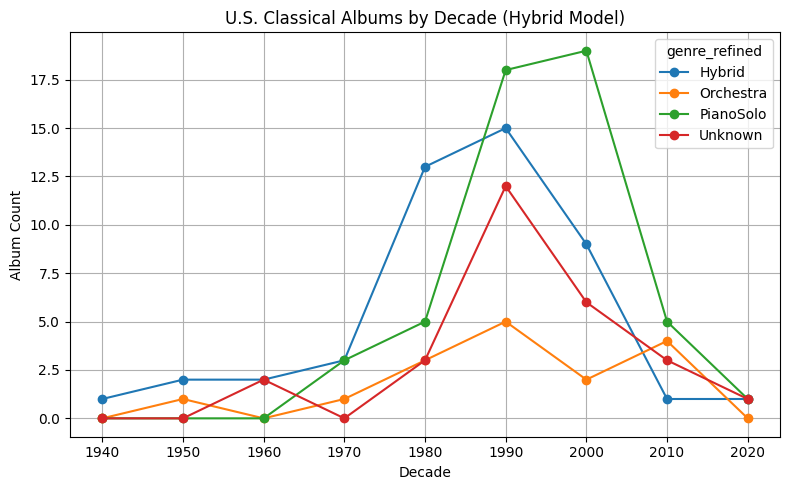

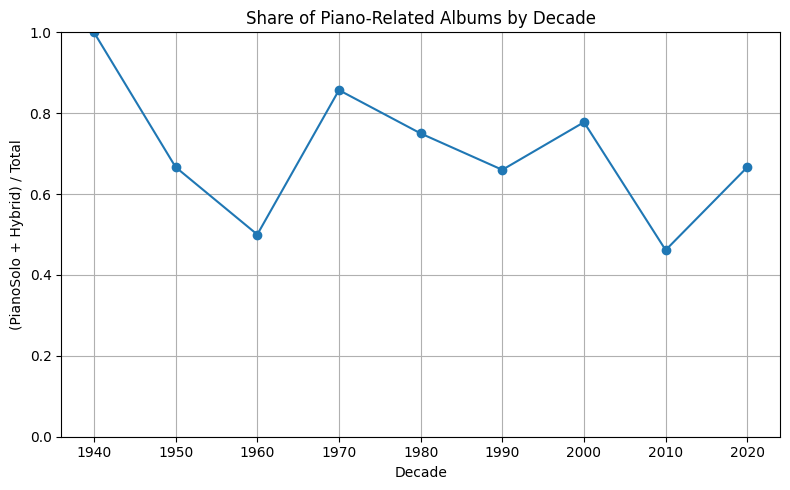

In [8]:
ax = pivot_h.plot(marker="o")
ax.set_title("U.S. Classical Albums by Decade (Hybrid Model)")
ax.set_xlabel("Decade"); ax.set_ylabel("Album Count")
plt.tight_layout(); plt.show()

total = pivot_h.sum(axis=1)
piano_related = (pivot_h.get("PianoSolo",0) + pivot_h.get("Hybrid",0))
ratio = (piano_related / total).replace([np.inf, np.nan], 0)

plt.figure()
plt.plot(ratio.index, ratio.values, marker="o")
plt.ylim(0,1); plt.title("Share of Piano-Related Albums by Decade")
plt.xlabel("Decade"); plt.ylabel("(PianoSolo + Hybrid) / Total")
plt.tight_layout(); plt.show()


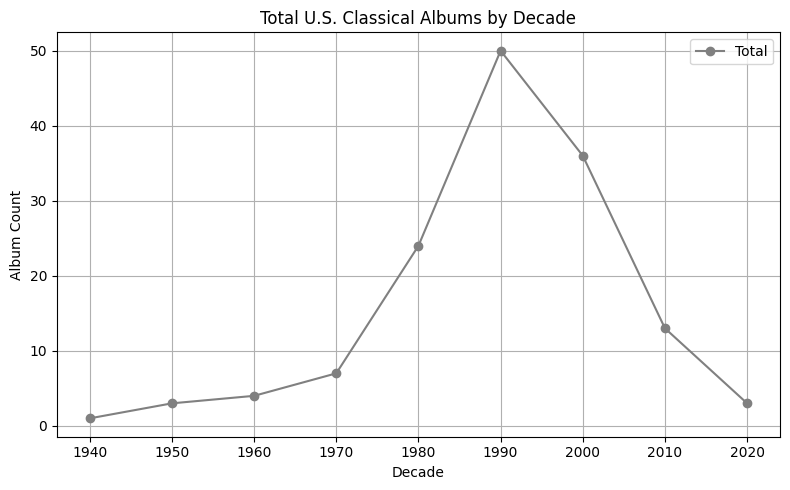

In [13]:
total.plot(marker="o", color="gray", label="Total")
plt.title("Total U.S. Classical Albums by Decade")
plt.xlabel("Decade"); plt.ylabel("Album Count")
plt.legend(); plt.tight_layout(); plt.show()

## 6) Title-level spot check

In [9]:
def sample_titles(df, decade, k=8):
    tmp = df[df["decade"]==decade]
    cols = [c for c in ["decade","title","release_title","genre_type","genre_refined","year"] if c in tmp.columns]
    return tmp[cols].sample(min(k, len(tmp)), random_state=42)

for d in [1980, 1990, 2000, 2010]:
    print(f"\n=== Samples {d}s ===")
    display(sample_titles(refined, d, k=8))



=== Samples 1980s ===


,decade,title,release_title,genre_type,genre_refined,year
50,1980,Piano Concerto no. 2 / Variations on a Theme b...,Piano Concerto No. 2 / Variations on a Theme b...,Piano,Hybrid,1989.0
108,1980,Piano Concerto No. 1,Piano Concerto No. 1,Piano,Hybrid,1988.0
4,1980,Works for Piano and Orchestra,"Piano Concerto No. 1 / Music for Strings, Perc...",Piano,Hybrid,1987.0
120,1980,Piano Concerto no. 20 / Piano Concerto no. 27,Piano Concerto no. 20 / Piano Concerto no. 27,Piano,Hybrid,1987.0
72,1980,Piano Music of Louis Moreau Gottschalk,Piano Music of Louis Moreau Gottschalk,Piano,PianoSolo,1984.0
57,1980,Tomasi: Concerto for Trumpet and Orchestra / J...,Tomasi: Concerto for Trumpet and Orchestra / J...,Piano,Hybrid,1986.0
90,1980,"Piano Concerto no. 12, K. 414 / Piano Concerto...","Piano Concerto no. 12, K. 414 / Piano Concerto...",Piano,Hybrid,1987.0
9,1980,Piano Music,Piano Music,Piano,PianoSolo,1987.0



=== Samples 1990s ===


,decade,title,release_title,genre_type,genre_refined,year
25,1990,Pictures at an Exhibition,Pictures at an Exhibition,Piano,Unknown,1994.0
111,1990,Piano Concertos,Piano Concertos,Piano,PianoSolo,1991.0
76,1990,The 5 Piano Concertos,The 5 Piano Concertos,Piano,PianoSolo,1999.0
127,1990,"The Piano Works, Volume I: Piano Sonata no. 1 ...","The Piano Works, Volume I: Piano Sonata no. 1 ...",Piano,PianoSolo,1993.0
33,1990,The 5 Piano Concertos,5 Piano Concertos,Piano,PianoSolo,1992.0
135,1990,Tchaikovsky: Piano Concerto no. 1 / Rachmanino...,Tchaikovsky: Piano Concerto no. 1 / Rachmanino...,Piano,Hybrid,1993.0
70,1990,The Nocturnes,The Nocturnes,Piano,Unknown,1993.0
68,1990,"Piano Sonatas: No. 14 ""Moonlight"" / No. 21 ""Wa...","Piano Sonatas: No. 14 ""Moonlight"" / No. 21 ""Wa...",Piano,PianoSolo,1991.0



=== Samples 2000s ===


,decade,title,release_title,genre_type,genre_refined,year
140,2000,The Piano Concertos,The Piano Concertos,Piano,PianoSolo,2006.0
49,2000,Symphony no. 5 / Elegy for Piano and String Or...,Symphony no. 5 / Elegy for Piano and String Or...,Piano,Hybrid,2007.0
95,2000,Minnesota Orchestra Showcase,Minnesota Orchestra Showcase,Orchestra,Orchestra,2000.0
109,2000,Piano Concerto No. 1,Piano Concerto No. 1,Piano,Hybrid,2006.0
56,2000,Works for Piano Solo 7,Works for Piano Solo 7,Piano,PianoSolo,2001.0
119,2000,Classically Cool Piano,Classically Cool Piano,Piano,PianoSolo,2000.0
82,2000,The Wings of a Film: The Music of Hans Zimmer,The Wings of a Film: The Music of Hans Zimmer,Orchestra,Unknown,2001.0
46,2000,Concerto for Piano & Orchestra - Suite for Pia...,Concerto for Piano & Orchestra - Suite for Pia...,Piano,Hybrid,2001.0



=== Samples 2010s ===


,decade,title,release_title,genre_type,genre_refined,year
125,2010,Piano Concertos 24-27,Piano Concertos 24-27,Piano,PianoSolo,2010.0
113,2010,Classical Favorites Sampler,Classical Favorites Sampler,Unknown,Unknown,2010.0
41,2010,The Piano Guys 2,The Piano Guys 2,Piano,PianoSolo,2013.0
112,2010,Asphalt Orchestra,Asphalt Orchestra,Orchestra,Orchestra,2010.0
87,2010,Orchestral Works,Orchestral Works,Orchestra,Unknown,2014.0
44,2010,The Piano Guys,The Piano Guys,Piano,PianoSolo,2012.0
42,2010,piano music,piano music,Piano,PianoSolo,2018.0
132,2010,The Chopin Album,The Chopin Album,Piano,Unknown,2012.0


## 7) Cross-tab: api label vs refined label

In [10]:
if "genre_type" in refined.columns:
    ct = pd.crosstab(refined["genre_type"], refined["genre_refined"])
    display(ct)


genre_refined,Hybrid,Orchestra,PianoSolo,Unknown
genre_type,,,,
Orchestra,0,14,0,5
Piano,47,2,51,17
Unknown,0,0,0,5


## 9) Save figures (for blog)

Saved: hybrid_decade_counts.png, hybrid_piano_share.png, hybrid_total_albums.png


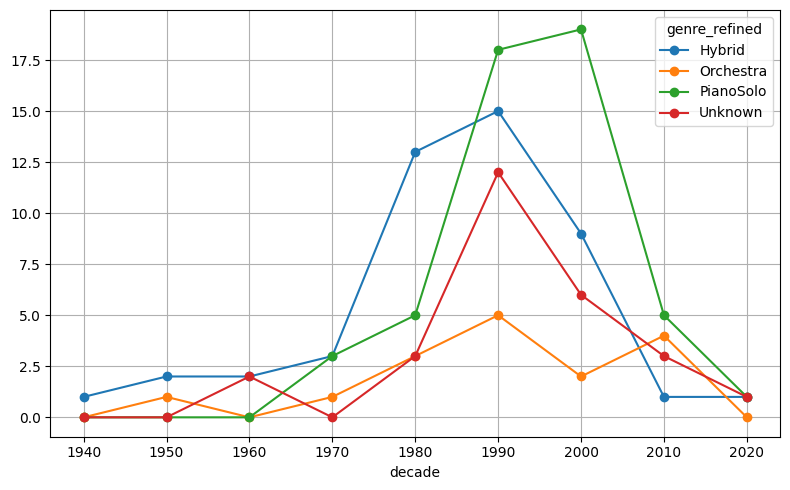

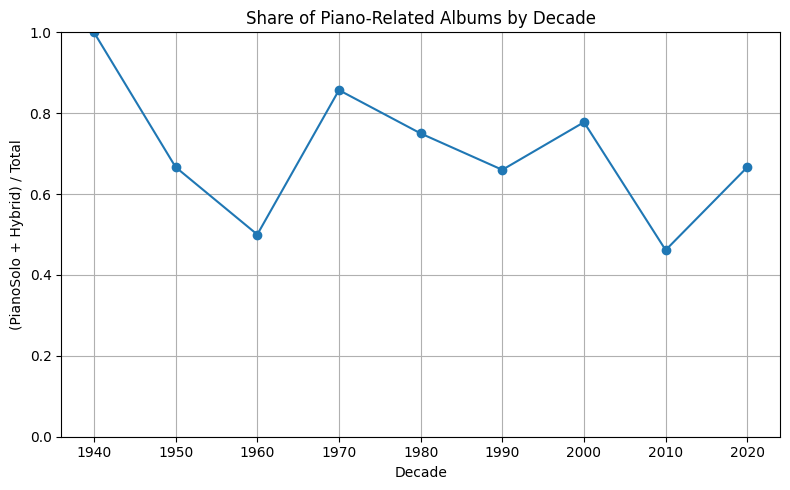

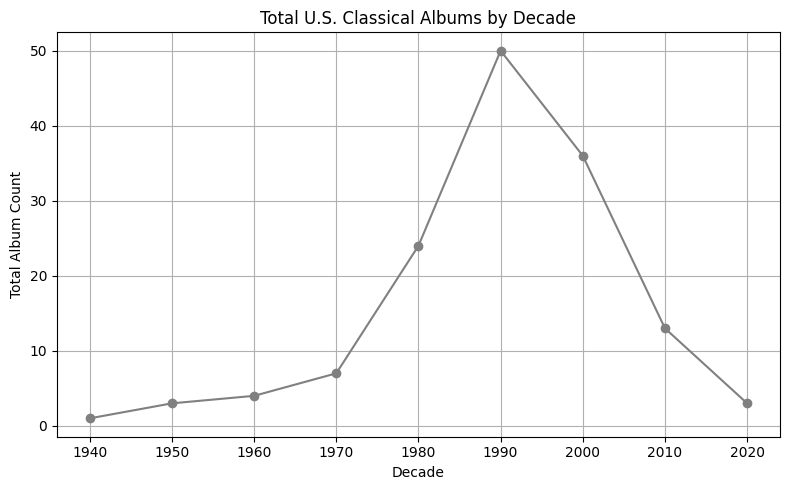

In [14]:
fig1 = pivot_h.plot(marker="o").get_figure()
fig1.tight_layout()
fig1.savefig("../blog/hybrid_decade_counts.png", dpi=160)

plt.figure()
plt.plot(ratio.index, ratio.values, marker="o")
plt.ylim(0, 1)
plt.title("Share of Piano-Related Albums by Decade")
plt.xlabel("Decade")
plt.ylabel("(PianoSolo + Hybrid) / Total")
plt.tight_layout()
plt.savefig("../blog/hybrid_piano_share.png", dpi=160)

plt.figure()
plt.plot(total.index, total.values, marker="o", color="gray")
plt.title("Total U.S. Classical Albums by Decade")
plt.xlabel("Decade")
plt.ylabel("Total Album Count")
plt.tight_layout()
plt.savefig("../blog/hybrid_total_albums.png", dpi=160)

print("Saved: hybrid_decade_counts.png, hybrid_piano_share.png, hybrid_total_albums.png")
